# Loewe Synergy Model

## 2D

The Loewe synergy model works by assuming that there is a constant "exchange rate" between each drug. An simple analogy is currency. Five \$1 bills totals \$5. If you remove two of the \$1 bills, but replace them with a total of 8 quarters ($0.25 value each) then the total value is still \$5. Loewe says that if the total value becomes > \$5, then quarters and dollars are synergistic, while if the total value becomes < \$5 dollars they are antagonistic.

In the case of drugs, rather than money, Loewe's model expects a linear tradeoff, such that withholding $x$ parts of drug 1 can be compensated for by adding $y$ parts of drug 2.

Multiple modes are supported, and specified by `model = Loewe(mode=mode)`
- `"ci"`
- `"delta_weakest"`
- `"delta_hsa"`
- `"delta_nan"`
- `"delta_synergyfinder"`

### Mode: `"ci"`

In `"ci"` mode, Loewe synergy is calculated using an equation identical to the Combination Index. Let $E := E(d_1, d_2)$
$$synergy(d_1, d_2) := \frac{d_1}{E_1^{-1}(E)} + \frac{d_2}{E_2^{-1}(E)}$$
Here $E_i^{-1}(d_i)$ means "the dose of drug $i$ that, alone, achieves effect $E$".

<div class="alert alert-block alert-warning"><b>Warning: </b> One weakness of this approach is that if the combination achieves greater effects than the individual drugs can achieve as single-agents, then $E_i^{-1}(d_i)$ becomes undefined. In these cases, $synergy(d_1, d_2) := \text{nan}$ </div>

The values of Loewe synergy in `"ci"` mode are interpreted as
| Value | Interpretation |
| - | - |
| $$< 1$$ | Synergistic |
| $$> 1$$ | Antagonistic |
| $$= 1$$ | Additive |

### Mode: `["delta_weakest", "delta_hsa", "delta_nan", "delta_synergyfinder"]`

In all `"delta"` modes, Loewe synergy is calculated as the difference between an "expected" dose-response surface ($E_{loewe}(d_1, d_2)$ and the observed one. Similar to `"ci"` mode, $E_{loewe}$ becomes ill-defined at doses where the stronger drug achieves effects greater than the weaker drug can achieve.

Each `"delta"` mode thus has its own approach to quantify $E_{loewe}(d_1, d_2)$ at doses for which this occurs:
- `"delta_weakest"` sets $E_{loewe}(d_1, d_2) = E_i(\inf)$, which is the maximum effect of the weaker drug
- `"delta_hsa"` sets $E_{loewe}(d_1, d_2) = \min(E_i(d_i))$, which is the effect of the stronger drug
- `"delta_nan"` sets $E_{loewe}(d_1, d_2) = \text{nan}$
- `"delta_synergyfinder"` sets $E_{loewe}(d_1, d_2) = E_i(d_1 + d_2)$ where $E_i$ is the stronger drug

The values of Loewe synergy in all `"delta"` modes are interpreted as
| Value | Interpretation |
| - | - |
| $$> 0$$ | Synergistic |
| $$< 0$$ | Antagonistic |
| $$= 0$$ | Additive |

### Load and plot example dataset
2D synergy models work with 1D arrays of drug 1 dose, drug 2 dose, and effect.

In [1]:
from synergy import datasets
from synergy.utils.plots import plot_heatmap

d1, d2, E = datasets.load_2d_example()

#### Plot raw dose response data as a heatmap using `synergy.utils.plots.plot_heatmap()`

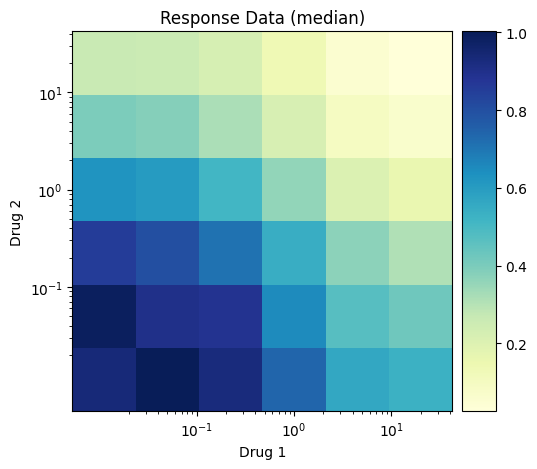

In [2]:
plot_heatmap(d1, d2, E, title="Response Data", cmap="YlGnBu")

### Calculate synergy using the Loewe model

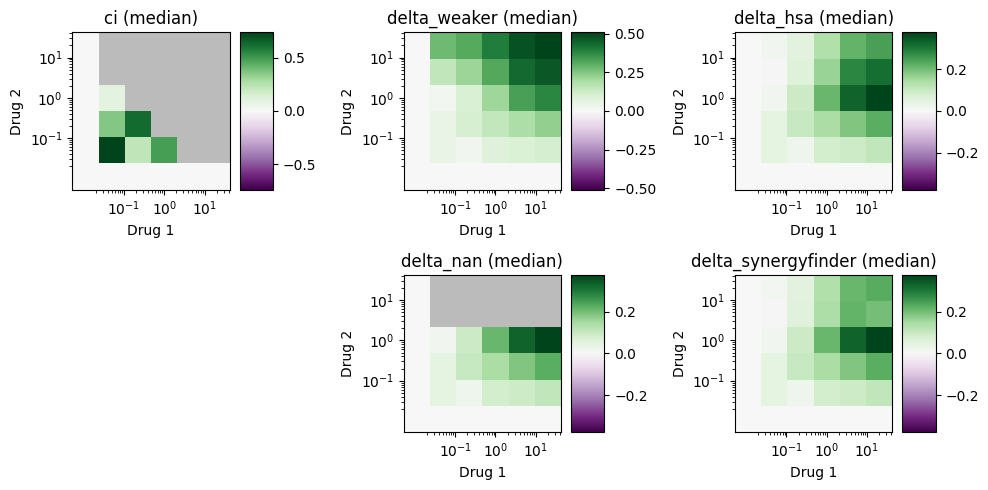

In [6]:
from synergy.combination.loewe import Loewe
from synergy.single.hill import Hill

# "ci" mode can work for non-sigmoidal single-drug dose-response curves
# However in this case the synthetic data do have a sigmoidal shape, so
# telling Loewe to use Hill equations tends to improve the results.
model_ci = Loewe(mode="ci", drug1_model=Hill, drug2_model=Hill)

# All "delta" modes automatically default to Hill equations
model_delta_weaker = Loewe(mode="delta")
model_delta_hsa = Loewe(mode="delta_hsa")
model_delta_nan = Loewe(mode="delta_nan")
model_delta_synergyfinder = Loewe(mode="delta_synergyfinder")

# Fit synergy
synergy_ci = model_ci.fit(d1, d2, E)
synergy_delta_weaker = model_delta_weaker.fit(d1, d2, E)
synergy_delta_hsa = model_delta_hsa.fit(d1, d2, E)
synergy_delta_nan = model_delta_nan.fit(d1, d2, E)
synergy_delta_synergyfinder = model_delta_synergyfinder.fit(d1, d2, E)

# Prepare a plot to show them all
from matplotlib import pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5))
# For ci mode, it is recommended to visualize negative-log synergy, so that values < 0 are antagonistic, and > 0 are synergistic
plot_heatmap(d1, d2, -np.log(synergy_ci), cmap="PRGn", title="ci", center_on_zero=True, ax=fig.add_subplot(2, 3, 1))
plot_heatmap(d1, d2, synergy_delta_weaker, cmap="PRGn", title="delta_weaker", center_on_zero=True, ax=fig.add_subplot(2, 3, 2))
plot_heatmap(d1, d2, synergy_delta_hsa, cmap="PRGn", title="delta_hsa", center_on_zero=True, ax=fig.add_subplot(2, 3, 3))
plot_heatmap(d1, d2, synergy_delta_nan, cmap="PRGn", title="delta_nan", center_on_zero=True, ax=fig.add_subplot(2, 3, 5))
plot_heatmap(d1, d2, synergy_delta_synergyfinder, cmap="PRGn", title="delta_synergyfinder", center_on_zero=True, ax=fig.add_subplot(2, 3, 6))
plt.tight_layout()

## N-drug Combinations

Currently only `"ci"` mode is implemented for $N$-drug combinations ($N > 2$). In this case, synergy is defined as

$$synergy(d_1, d_2) := \sum_{i=1}^{N}\frac{d_i}{E_i^{-1}(E)}$$

Synergy is interpreted identically as in the 2D case.

In [24]:
from synergy.higher.loewe import Loewe as LoeweND
from synergy import datasets
from synergy.single.hill import Hill

d, E = datasets.load_3d_example()
model = LoeweND(single_drug_models=[Hill, Hill, Hill])
synergy = model.fit(d, E)

# Because synergy has many NaNs, it is difficult to visualize using plotly plots
print(np.vstack([d[:, 0], d[:, 1], d[:, 2], E, synergy]).transpose())

[[ 0.      0.      0.      0.9968  1.    ]
 [ 0.      0.      0.05    0.9068  1.    ]
 [ 0.      0.      0.2236  0.789   1.    ]
 ...
 [20.     20.      1.      0.3251     nan]
 [20.     20.      4.472   0.1706     nan]
 [20.     20.     20.      0.1144     nan]]
